# Correlation Length in the Ising Model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100

from numba import njit         # Import this if you're using @njit to speed up your code
from tqdm import tqdm          # This is a very cool package that allows you to see a "progress bar" to know how far a loop has progressed

from scipy.optimize import curve_fit # This function is needed to perform non-linear curve-fitting to extract the correlation length from the correlation function

In [2]:
@njit                                     # Once you've written your code using only numpy arrays, you can choose to speed it up using this command
def pbc_distance(rij, L):
    '''
    Get the correct distance between two spins, accounting for periodic boundary conditions.
    
    Parameters:
    -----------
    • rij : A numpy array of 2 elements storing the `x` and `y` values of the separation `rij`.
    
    Returns:
    --------
    The function returns one value:
    • rij : The corrected rij, including the effects of periodic boundary conditions.
    '''
    
    for d in range(2):
        if abs(rij[d])>0.5*L:                    # Compute the _true_ distance, taking into account
            rij[d] -= L*np.sign(rij[d])          # periodic boundary conditions
    
    return rij

In [3]:
@njit                                     # Once you've written your code using only numpy arrays, you can choose to speed it up using this command
def oneMCS(spins, beta, h, energy, J=1):
    '''
    Perform a single Monte-Carlo sweep on a lattice of spins. The function accepts an array of spins, the 
    inverse temperature, and the external magnetic field. The total system energy is also accepted in order
    to compute the change in energy more efficiently.
    
    Parameters:
    -----------
    • spins  : A 2D numpy array of L x L elements storing the L**2 spins.
    • beta   : The inverse temperature at which to simulate the lattice.
    • h      : Value of the external magnetic field.
    • energy : The total energy of the supplied spin lattice.
    • J      : The coupling constant (by default, this is 1).
    
    Returns:
    --------
    The function returns one value:
    • energy : The total energy of the newly updated spin lattice.
    • spins  : The newly updated spin lattice. 
    '''
    
    L = np.shape(spins)[0]
    N = L**2
    for i in range(N):
        p,q = np.random.randint(L), np.random.randint(L)          # Choose a random spin
        
        this_energy = -J*spins[p][q]*(spins[(p-1)][q] + spins[(p+1)%L][q] + spins[p][(q-1)] + spins[p][(q+1)%L])
        
        new_energy  = - this_energy
        
        dE = new_energy - this_energy

        if(dE<=0 or np.random.uniform(0,1)<np.exp(-beta*dE)):  # If a flip should happen
            spins[p][q] = -spins[p][q]                         # Flip the spin
            energy += dE                                       # Change the energy

    return spins, energy

In [4]:
@njit                                     # Once you've written your code using only numpy arrays, you can choose to speed it up using this command
def simulate(L, beta, h, J=1, n_mcs = 10_000):
    '''
    Simulate a number of Monte-Carlo sweeps on a lattice of some size L.
    
    Parameters:
    -----------
    • L    : The side-length of the square lattice.
    • beta : The inverse temperature at which to simulate the lattice.
    • h    : Value of the external magnetic field.
    • J    : The coupling constant (by default, this is 1).
    • n_mcs: Number of Monte-Carlo sweeps.
    
    Returns:
    --------
    The function returns one value:
    • all_spins    : An array of `(n_mcs x L x L)` elements with each spin configuration per Monte-Carlo step.
    • systemEnergy : An array of the system's energy as a function of Monte-Carlo step.
    • m            : An array of the system's magnetisation as a function of Monte-Carlo step.
    '''
    
    N=L**2                                             # Total number of spins
    
    spins = 2*np.random.randint(0,2,size=(L,L)) - 1    # Initial array of random +1 and -1 assignments
    
    all_spins = np.zeros((n_mcs, L,L))                 # Array to store all spin configurations
    
    systemEnergy = np.zeros(n_mcs)                     # Array to store system energies
    m = np.zeros_like(systemEnergy)                    # Array to store system magnetisation
    
    for i in range(L):                                 # Looping over spins, compute initial energy and magnetisation
        for j in range(L):
            systemEnergy[0] += -(J/2)*spins[i][j]*(spins[(i+1)%L][j] + spins[i][(j+1)%L] + spins[(i-1)][j] + spins[i][(j-1)]) -h*spins[i][j]    # Set the initial system energy
            m[0] += spins[i][j]/N
    
    for mc in range(n_mcs):                            # For each MC step
        spins, systemEnergy[mc] = oneMCS(energy=systemEnergy[mc-1], beta=beta, h=h, spins=spins, J=J) # Perform a sweep
        m[mc] = np.mean(spins)                         # Find average magnetisation
        all_spins[mc] = spins                          # Store current configuration in `all_spins`

    return all_spins, systemEnergy, m

In [5]:
@njit                                     # Once you've written your code using only numpy arrays, you can choose to speed it up using this command
def get_correlation(spins):
    '''
    Compute the correlation function for a single lattice of spins.
    
    Parameters:
    -----------
    • spins  : A 2D numpy array of L x L elements storing the L**2 spins.
    
    Returns:
    --------
    The function returns one value:
    • r  : Distances at which correlations are computed.
    • Cr : Correlation function at those distances.
    '''

    L = len(spins)             # Get the side-length of the square lattice
 
    N = L**2                   # Get the total number of spins
    
    n_bins = int(L/np.sqrt(2)) # Maximum number of distance bins possible (since the smallest distance is sqrt(2))

    r = np.linspace(1, L/np.sqrt(2), n_bins)     # Array to hold different distances
    dr = np.diff(r)[0]                           # Spacing between the distance bins
    
    nr = np.zeros_like(r)                        # Array to store number of spins at specific distance bin
    Cr = np.zeros_like(r)                        # Array to store correlation for each distance bin
    m_sqr = (np.sum(spins)/N)**2                 # Calculate m**2 for the entire lattice

    for i in range(L):                           # Loop over all spin pairs. Note that if we naively looped over
        for j in range(L):                       # all spins, we would be counting each pair twice. To avoid this
            for p in range(i,L):                 # the second spin always has coordinates (p,q)>(i,j).
                for q in range(j,L):
                    rij = np.array([p-i, q-j])   # Get the separation between the spins
                    rij = pbc_distance(rij,L)    # Calculate true separation (including boundary conditions)
                    dist = np.sqrt(rij[0]**2 + rij[1]**2) # Compute the distance
                    corr = spins[i,j]*spins[p,q] - m_sqr  # Compute the correlation for this pair

                    this_bin = int(dist/dr)      # Choose bin to place correlation in 
                    nr[this_bin] += 1            # Increment number in that bin
                    Cr[this_bin] += corr         # Add correlation to appropriate bin

    r = r        # Exclude the last values, since the last bin is always empty.
    Cr = Cr/nr   # The real correlation function is the average over the number of pairs
    
    return r, Cr

In [6]:
@njit                                     # Once you've written your code using only numpy arrays, you can choose to speed it up using this command
def correlations_with_temps(L, Ts, n_mcs=2000, step=10):
    '''
    Simulate lattices of size `L` and compute the correlation function for a range of different temperatures.
    
    Parameters:
    -----------
    • L    : The side-length of the square lattice.
    • Ts   : An array of temperatures at which to compute the correlation function.
    • step : Average one in every `step` configuration for each temperature.
    
    Returns:
    --------
    The function returns one value:
    • each_temp_rs : An array of `(n_mcs x L x L)` elements with each spin configuration per Monte-Carlo step.
    • each_tem_Crs : An array of the system's energy as a function of Monte-Carlo step.
    '''

    n_bins = int(L/np.sqrt(2)) # Maximum number of distance bins possible (since the smallest distance is sqrt(2))
    
    each_temp_rs = np.zeros((len(Ts), n_bins))
    each_temp_Crs = np.zeros_like(each_temp_rs)
    
    for i in range(len(Ts)):
        all_spins, _, _ = simulate(L=L, beta=1/Ts[i], h=0, n_mcs=n_mcs)
        
        all_spins_rs = np.linspace(1, L/np.sqrt(2), n_bins) # Array to hold the (average) distances r
        all_spins_Crs = np.zeros_like(all_spins_rs)         # Array to hold the (average) correlations for a temperature

        for s in range(0,n_mcs):
            each_step_r, each_step_Cr = get_correlation(all_spins[s])
            all_spins_rs += each_step_r
            all_spins_Crs += each_step_Cr
        
        all_spins_rs = all_spins_rs/n_mcs
        all_spins_corrs = all_spins_Crs/n_mcs
        
        each_temp_rs[i] = all_spins_rs; each_temp_Crs[i] = all_spins_Crs
        
    return each_temp_rs, each_temp_Crs

In [7]:
%%time
###########################################################
##### Compute correlation functions at different Ts #######
###########################################################

# For 1 temperature, L=32, and n_mcs=2000, this should take 
# about ~ 42 min without Numba, and ~ 20 s with Numba. 
# For interesting results, you need around 5 to 10 temperatures,
# meaning that it will take far too long without Numba!

Tc = 2/np.log(1+np.sqrt(2))        # Exact critical temperature for the 2D Ising model
Ts = np.linspace(2.5, 5, 12)       # Array of temperatures at which to compute correlation length

combined_rs, combined_corr_fns = correlations_with_temps(L=32, Ts=Ts, n_mcs=2_000)

CPU times: user 4min 6s, sys: 558 ms, total: 4min 7s
Wall time: 4min 10s


In [8]:
def get_correlation_length(r, Cr, p0=(1,1,1), plot_fit=False, fig=None, ax=None, color=None):
    '''
    Get the correlation length given a correlation function, using the assumption that the correlation
    function falls off exponentially with the correlation length as the scale parameter.
    
    Parameters:
    -----------
    • r  : Distances at which correlations are computed.
    • Cr : Correlation function at those distances.
    • p0 : Initial guesses for the parameters of the exponential. (Defaults are all 1s.)
    
    Returns:
    --------
    The function returns one value:
    • xi : The correlation length.
    '''
    
    def fit(x, A, xi, C):
        "A fitting function to send to scipy.optimize.curve_fit to fit a shifted and scaled exponential decay."
        return A*np.exp(-x/xi)+C
    
    (A,xi,C), covar = curve_fit(fit, r, Cr, p0=p0) # Perform non-linear curvefitting to find xi
    
    if(plot_fit):
        if(fig is None or ax is None):
            fig, ax = plt.subplots()
        
        ax.scatter(r, Cr, color=color, ec='k')
        ax.plot(r, fit(r, A, xi, C), color='indianred')
    
    return xi

<div class="alert alert-block alert-warning">
   
<b>Comment:</b> The above function takes in a data for the correlation function as a function of distance, and performs a non-linear fit of the form
    
\begin{equation} C(r) = A e^{-r/\xi} + C.\end{equation}
    
In general, it is not advisable to perform non-linear fits since such fits often have multiple equivalent solutions. Normally, it would have been better to have tried to solve this problem using linear regression. (Taking the log of $C(r)$ and trying to fit that as a function of $r$, for example. However, since we are working with small lattices and a relatively low number of Monte-Carlo sweeps, our correlation function occassionally dips into the negative. This is because the "average" magnetisation which we are removing during the process of computing the correlation per spin-pair requires many more spins and steps to be accurate. 
    
An unfortunate consequence of this is that these points will not show up in a log-linear plot. Therefore, a decision was made to instead fit a "shifted" exponential (shifted by some constant $C$) that will take into account this overall negative sign. This non-linear fitting would then give the correlation length $\xi$ as one of the fit parameters. 
    
In the plots shown below, the closeness of fit between the correlation function and the exponential decay is quite striking, and is suggestive of the fact that we chose the right function.
    
</div>

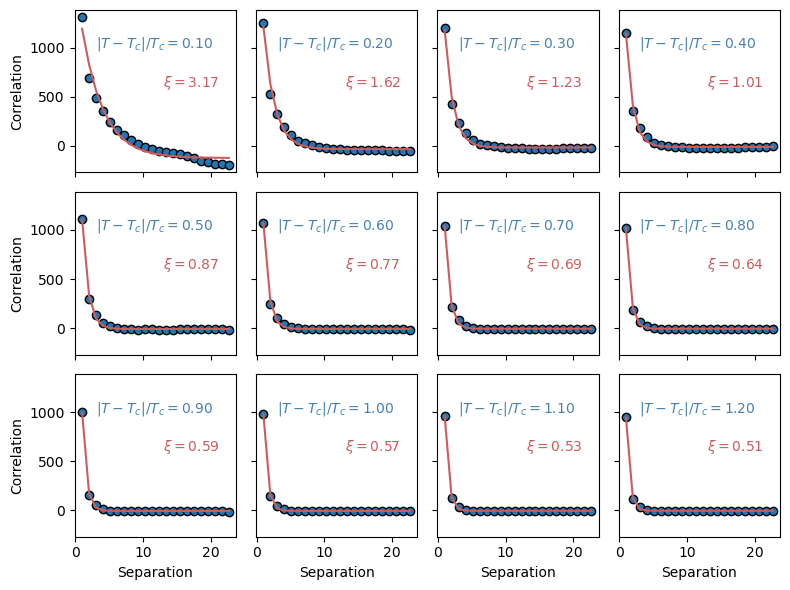

In [9]:
##################################
#### The correlation function ####
##################################

ncols = 4; nrows = len(Ts)//ncols;                             # Number of rows and columns of plotting grid
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8,6), sharex=True, sharey=True) # Define a grid of plots

xi_per_T = np.zeros_like(Ts)                                   # Array to store correlation lengths

for i in range(len(combined_rs)):                              # For each of the computed correlation functions
    xi_per_T[i] = get_correlation_length(combined_rs[i],       # plot the correlation function and its exponential
                                         combined_corr_fns[i], # fit, and get the correlation length from the fit.
                                         plot_fit=True, 
                                         fig=fig, ax=axes[i//ncols][i%ncols])
    axes[i//ncols][i%ncols].text(3,1000, f"$|T-T_c|/T_c= {(Ts[i]-Tc)/Tc:.2f}$", color='steelblue') # Annotate plots
    axes[i//ncols][i%ncols].text(13,600, rf"$\xi= {xi_per_T[i]:.2f}$", color='indianred')
    
    if(i%ncols == 0):                                      # Add y-labels for the first column in every row
        axes[i//ncols][i%ncols].set_ylabel("Correlation")
    if(i//ncols == nrows-1):                               # Add x-labels for the last row in every column
        axes[i//ncols][i%ncols].set_xlabel("Separation")

plt.tight_layout()

<div class="alert alert-block alert-warning">
   
<b>Comment:</b> We can see that the correlation length seems to fall as we move further away from the critical temperature. Close to $T=T_c$, the correlation length is not very reliable since we have used the Metropolis algorithm in which a very large number of Monte-Carlo sweeps is needed to equilibriate a system close to its critical temperature. (This is called _critical slowing down_.) 
    
 We can now see how the correlation length varies as a function of the reduced temperature $\left(\frac{|T-T_c|}{T_c}\right)$, a dimensionless quantity that measures the "distance" from the critical point. Theoretical studies have told us that we would expect a power-law type behaviour, i.e.
    
\begin{equation} \xi \sim |T-Tc|^{-\nu}.\end{equation}
    
The parameter $\nu$ is a critical exponent for the model . Note that $\nu$ is generally assumed to be positive, even though the power-law dependence is overall negative.
    
</div>

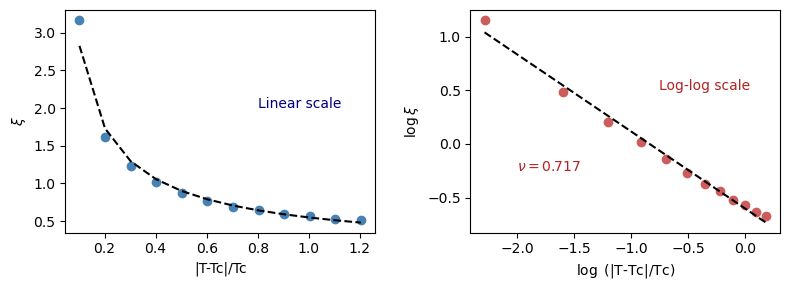

In [10]:
#####################################
###### The critical exponent ν ######
#####################################

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,3))

xdata = (Ts-Tc)/Tc
ydata = xi_per_T

z = np.poly1d(np.polyfit(np.log(xdata), np.log(ydata), deg=1))         # Fit a straight line in a log-log plot

axes[0].scatter(xdata, ydata, color='steelblue')                       # Plot the data
axes[0].plot(xdata, np.exp(z(np.log(xdata))), color='k', ls='--')      # Plot the fit
axes[0].set_xlabel("|T-Tc|/Tc")                                        # Label the axes
axes[0].set_ylabel(r"$\xi$")
axes[0].text(0.8,2, "Linear scale", color='navy')                      # Annotate the graph

axes[1].scatter(np.log(xdata), np.log(ydata), color='indianred')       # Plot the data on a log scale
axes[1].plot(np.log(xdata), z(np.log(xdata)), color='k', ls='--')      # Plot the fit on a log scale
axes[1].set_xlabel("$\log$ (|T-Tc|/Tc)")                               # Label the axes
axes[1].set_ylabel(r"$\log \xi$")
axes[1].text(-0.75, 0.5, "Log-log scale", color='firebrick')           # Annotate the graph
axes[1].text(-2, -0.25, rf"$\nu = {-z[1]:.3f}$", color='firebrick')    # Annotate the graph
plt.tight_layout()

<div class="alert alert-block alert-warning">
   
<b>Comment:</b> In the above plots we see that the correlation length seems to behave like a power law when we approach $T=T_c$. The power-law exponent $\nu$ (a so-called "critical" exponent that you will learn more about later) can be found computationally to be around $\nu \approx 0.7$.
    
The actual "theoretical" value of this exponent for the two-dimensional Ising model is $\nu = 1$. However, in order to get this behaviour, one would need to simulate the system very close to $T=T_c$ (a difficult task because of the critical slowing down behaviour described earlier), and for much larger lattices, and for many more time-steps until the system is truly equilibriated. However, for this simple exercise, this result is sufficiently good.
    
One conclusion we can draw from this power-law behaviour is that as $T\to T_c$, since this is a power-law with a negative slope, $\xi$ must blow up! In other words, our results seem to suggest that as we approach the critical point, the correlation length diverges. Of course, we have not rigorously proven that here, however, theoretical studies have shown that this is indeed the case.
    
</div>